#  

## Traveling Salesperson Problem (TSP) – Heuristic with Transformers

### Introduction

The Traveling Salesperson Problem (TSP) is a classical combinatorial optimization problem: given a set of cities and the distances between them, the goal is to find the shortest possible tour that visits each city exactly once and returns to the starting point. See this picture for reference. 

![TSP](https://optimization.cbe.cornell.edu/images/e/ea/48StatesTSP.png)

TSP is NP-hard, meaning that finding the optimal solution becomes computationally intractable as the number of cities grows. Therefore, in practice, we often rely on heuristic or approximate algorithms to find good solutions in a reasonable time.

In this assignment, your task is to implement a heuristic TSP solver for Euclidean TSP using a Transformer-based model. 

Euclidean TSP is a TSP where all the cities are assumed to be in the Euclidean 2D space and the distance is computed acording to the standard Euclidean norm.

The Transformer architecture, widely used in natural language processing, can also model sequences of nodes in a graph. By training a Transformer on TSP instances, you can generate tours in an autoregressive manner selecting one city at a time based on previously chosen cities.

This assignment will help you to understand how sequence models like Transformers can be applied beyond text, to combinatorial problems and practice autoregressive generation and masking techniques for sequence prediction.

Most of the code is provided. This **does not mean that you are allowed to use it blindly**: make sure to understand what is happening.

In [1]:
import networkx as nx
import torch
import torch.nn as nn
import math
from networkx.algorithms.approximation import greedy_tsp
import numpy as np
import pickle
import torch.optim as optim
from tqdm import tqdm
from typing import List
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# High-Performance Device Configuration
if torch.cuda.is_available():
    DEVICE = "cuda"
    print("Using Device: CUDA (NVIDIA GPU)")
elif torch.backends.mps.is_available():
    DEVICE = "mps"
    print("Using Device: MPS (Apple Silicon GPU)")
else:
    DEVICE = "cpu"
    print("Using Device: CPU")

Using Device: CUDA (NVIDIA GPU)


### Task 1 (0 pts)

Learn how to use the [NetworkX](https://networkx.org/documentation/stable/tutorial.html) package. The section on Graphs should be sufficient for this assignment. You can skip the sections on directed graphs and beyond.


### Utility Functions

Below are some utility functions. Detailed explanations are provided in each function’s description. At a high level, these functions do the following:

* `random_tour`: Takes a `networkx.Graph` as input and returns a random tour. This can serve as a simple heuristic, but its performance is generally low, as expected.
* `tour_length`: Takes a `networkx.Graph` and a tour (encoded as a `list` that starts and ends at the same node) and returns the total length of the tour.
* `gap`: Measures the quality of a tour by computing

$$ \dfrac{\text{Estimated} - \text{Optimal}}{\text{Optimal}} $$

As you might expect, lower values are better, with a gap of zero indicating that the tour is exactly optimal.


In [2]:
def random_tour(G: nx.Graph) -> List[int]:
    """
    Generate a random TSP tour for a given graph.

    Parameters
    ----------
    G : networkx.Graph
        A graph representing the TSP instance. Nodes should be numbered from 0 to n-1.

    Returns
    -------
    tour : list of int
        A list of node indices representing a complete tour starting and ending at node 0.
        Each node appears exactly once in the tour (except the start/end node).
    """
    n = G.number_of_nodes()
    tour = [0]
    for _ in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)
    return tour

def tour_length(G: nx.Graph, tour: List[int]) -> float:
    """
    Compute the total length/cost of a tour in a (weighted) graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph representing the TSP instance.
    tour : list of int
        A list of node indices representing a complete tour starting and ending at node 0.

    Returns
    -------
    length : float
        Sum of edge weights along the tour.
    """
    if len(tour) < 2:
        raise ValueError("Tour must contain at least 2 nodes (start and end).")
    if tour[0] != tour[-1]:
        raise ValueError("Tour must start and end at the same node.")
    if any(v not in G for v in tour):
        missing = [v for v in tour if v not in G]
        raise ValueError(f"Tour contains nodes not in graph: {missing}")

    total = 0.0
    for u, v in zip(tour[:-1], tour[1:]):
        if not G.has_edge(u, v):
            raise ValueError(f"Tour uses missing edge ({u}, {v}).")
        total += float(G[u][v].get("weight", 1.0))

    return total

def gap(estimated : float, optimal : float) -> float:
    """
    Compute the relative optimality gap of a TSP tour.

    Parameters
    ----------
    estimated : float
        The total cost of the computed tour.
    optimal : float
        The cost of the known optimal tour.

    Returns
    -------
    gap : float
        The relative gap between the estimated and optimal cost,
        computed as (estimated - optimal) / optimal.
    """
    return (estimated - optimal) / optimal

In [3]:
# We are creating a small sample graph to understand the structure we will be using

# Adding 3 nodes (cities
G_example = nx.Graph()
G_example.add_nodes_from([0, 1, 2])

# Adding weighted edges (distances)
# the weight simulates the distance between cities
G_example.add_edge(0, 1, weight=1.0)
G_example.add_edge(1, 2, weight=2.5)
G_example.add_edge(2, 0, weight=1.5)

print(f"NetworkX version {nx.__version__} working.")
print(f"Graph created: {G_example.number_of_nodes()} nodes, {G_example.number_of_edges()} edges.")
print(f"Example weighted edge(0-1): {G_example[0][1]['weight']}")

NetworkX version 3.5 working.
Graph created: 3 nodes, 3 edges.
Example weighted edge(0-1): 1.0


### Task 2 (10 pts)

The dataset has already been prepared for your convenience and is split into training, validation, and test sets. Load it using [pickle](https://docs.python.org/3/library/pickle.html).

For this task, focus on the case **$n = 20$**, i.e., solving a TSP with 20 cities. Inspect each item in the dataset: what type is it? You should see that it is a `tuple` consisting of a `networkx` graph and a list representing the optimal tour (our ground truth).

Answer the following questions carefully:

* What does the node attribute `pos` represent?
* What does the edge attribute `weight` represent?
* What does the boolean edge attribute `tour` represent?

Do not proceed until you fully understand each of these components.


In [4]:
def load_split_dataset():
    # Names of the files as seen in your screenshot
    file_names = {
        "train": "train_20_DLL_ass4.pkl",
        "val":   "valid_20_DLL_ass4.pkl",
        "test":  "test_20_DLL_ass4.pkl"
    }
    
    # Kaggle search paths
    search_paths = ["/kaggle/working", "/kaggle/input"]
    
    loaded_data = {}
    
    print(f"Searching for separated dataset files...")

    # Loop through each required file type (train, val, test)
    for key, target_file in file_names.items():
        found_path = None
        
        # Search mechanism
        for search_root in search_paths:
            if not os.path.exists(search_root): continue
            
            for root, dirs, files in os.walk(search_root):
                if target_file in files:
                    found_path = os.path.join(root, target_file)
                    break
            if found_path: break
        
        # Load logic
        if found_path:
            print(f"FOUND {key} set: {found_path}")
            with open(found_path, 'rb') as f:
                loaded_data[key] = pickle.load(f)
        else:
            print(f"ERROR: Could not find file '{target_file}'")
            return None, None, None

    return loaded_data["train"], loaded_data["val"], loaded_data["test"]

# Execute Loading 
train_data, val_data, test_data = load_split_dataset()

if train_data is not None:
    print(f"\n Dataset loaded successfully!")
    print(f"   Train size: {len(train_data)}")
    print(f"   Val size:   {len(val_data)}")
    print(f"   Test size:  {len(test_data)}")

    # Inspection for Task 2
    # We take the first element to answer questions (Sometimes split datasets store items directly, sometimes as tuples.)
    first_item = train_data[0]
    
    # If the dataset is a list of tuples (Graph, Solution), we unpack it
    if isinstance(first_item, tuple) or isinstance(first_item, list):
        sample_graph = first_item[0]
    else:
        # Fallback if structure is different
        sample_graph = first_item

    print("\nData Inspection (Task 2 Answers)")
    
    # 1. Inspect 'pos'
    if nx.get_node_attributes(sample_graph, 'pos'):
        node_pos = sample_graph.nodes[0]['pos']
        print(f"1. Node 'pos': {node_pos}")
        print(f"   -> Meaning: Euclidean coordinates (x,y) of the city.")
    
    # 2. Inspect weight and tour
    if sample_graph.edges:
        u, v, attrs = list(sample_graph.edges(data=True))[0]
        print(f"2. Edge attributes: {attrs}")
        print(f"   -> 'weight': Euclidean distance between cities.")
        print(f"   -> 'tour': Boolean (True if edge is part of optimal path).")
        
else:
    print("\nCRITICAL: Files not found. Check if 'data.zip' is uploaded and unzipped.")

Searching for separated dataset files...
FOUND train set: /kaggle/input/tsp-project-data/data/train_20_DLL_ass4.pkl
FOUND val set: /kaggle/input/tsp-project-data/data/valid_20_DLL_ass4.pkl
FOUND test set: /kaggle/input/tsp-project-data/data/test_20_DLL_ass4.pkl

 Dataset loaded successfully!
   Train size: 50000
   Val size:   1000
   Test size:  1000

Data Inspection (Task 2 Answers)
1. Node 'pos': (0.6049077053425551, 0.5748590937018008)
   -> Meaning: Euclidean coordinates (x,y) of the city.
2. Edge attributes: {'weight': np.float64(0.4287846201876535), 'tour': 0}
   -> 'weight': Euclidean distance between cities.
   -> 'tour': Boolean (True if edge is part of optimal path).


### Taks 3 (4 pts)

In this task, you will implement a custom PyTorch Dataset to handle TSP instances. Your dataset should take as input a list of tuples, where each tuple contains:

1. A `networkx` graph representing the cities and their distances.
2. A list representing the optimal tour (ground truth).

You should implement a class `TSPDataset` that returns, for a given index `idx`, a tuple `(X, opt_tour)` where:

  * `X` is a tensor of shape `[n_nodes, 2]` containing the coordinates of each node (from the node attribute `pos`).
  * `opt_tour` is a tensor containing the optimal tour as a sequence of node indices.

Then, create a dataset object for both training, validation and test sets.

In [5]:
class TSPDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        G, opt_tour = self.data[idx]
        
        # 1. Coordinate Extraction
        coords = [G.nodes[i]['pos'] for i in range(G.number_of_nodes())]
        X = torch.tensor(coords, dtype=torch.float32)
        
        # Min-Max Normalization
        # Normalize everything between 0.0 and 1.0 for each graph.
        if X.numel() > 0:
            min_val = torch.min(X, dim=0)[0] # Min for x and y axis
            max_val = torch.max(X, dim=0)[0] # Max for x and y axis
            
            # Avoid division by zero if all points are identical
            denom = max_val - min_val
            denom[denom == 0] = 1.0 
            
            X = (X - min_val) / denom
        
        opt_tour_tensor = torch.tensor(opt_tour, dtype=torch.long)
        return X, opt_tour_tensor

# Dataset Creation 
train_dataset = TSPDataset(train_data)
val_dataset = TSPDataset(val_data)
test_dataset = TSPDataset(test_data)

print("Min-Max Normalized Dataset created.")

Min-Max Normalized Dataset created.


### Task 4 (3 pts)

Create the `Dataloader` objects for training and validation. Probably you just need training and validation loader.

In [6]:
# Task 4: DataLoaders
from torch.utils.data import DataLoader

# Hyperparameter Configuration
BATCH_SIZE = 128

# pin_memory=True speeds up Host-to-Device data transfer using GPU
use_pin_memory = True if DEVICE != "cpu" else False  

# 1. Training Loader
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  # Shuffle breaks correlations between consecutive samples
    pin_memory=use_pin_memory
)

# 2. Validation Loader
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, # We want deterministic results for validation
    pin_memory=use_pin_memory
)

print("DataLoaders configured.")
print(f"Training Batches: {len(train_loader)} (Batch Size: {BATCH_SIZE})")
print(f"Validation Batches: {len(val_loader)}")
print(f"Pin Memory: {use_pin_memory} (Optimization of GPU)")

DataLoaders configured.
Training Batches: 391 (Batch Size: 128)
Validation Batches: 8
Pin Memory: True (Optimization of GPU)


### Task 5 (5 pts)

Implement Positional encoding for sequence models. Positional encoding allows a Transformer to incorporate information about the order of elements in a sequence, since the model itself is permutation-invariant.

You are asked to implement a function/a class that takes as input:

  * `seq_len`: the length of the sequence (number of positions).
  * `embed_dim`: the dimensionality of the embedding vectors.

And returns a tensor of shape `[seq_len, embed_dim]`, where each row corresponds to the positional encoding vector for a position in the sequence.

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, embed_dim):
        """
        Args:
            max_seq_len: Maximum manageable sequence length.
            embed_dim: Latent space dimension (d_model)
        """
        super().__init__()
        
        # Create a matrix filled with zeros
        pe = torch.zeros(max_seq_len, embed_dim)
        
        # Position vector 
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim)) #Divisor term for frequencies
        
        # Application of sin (even index) and cos (odd index)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add the batch dimension
        pe = pe.unsqueeze(0)
        
        # register_buffer tells PyTorch this tensor is part of the model state but is not a parameter, so it won't be updated by gradient descent.
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: input tensor [Batch, Seq_Len, Embed_Dim]
        Returns:
            x + positional_encoding
        """
        #Slice the pe matrix to match the input sequence length (x.size(1)) and add it to the input
        x = x + self.pe[:, :x.size(1), :]
        return x

print("PositionalEncoding class defined.")

PositionalEncoding class defined.


### Task 6 (30 pts)

In this task, you are asked to implement a Transformer-like architecture. You have two options:

1. Implement the architecture provided in the pdf and sketched with guidance in the next cell. This option is fully guided, however, following it exactly will give you full points.

2. Implement your own Transformer-based architecture. You are free to design it as you wish, as long as it is Transformer-based. No extra points will be awarded for choosing this option, but full points can still be earned if it works correctly.

Choose the approach that best suits your preference and experience.

In [8]:
class TSPTransformer(nn.Module):
    def __init__(self, n, d_model, nhead_encoder, nhead_decoder, n_encoder_layers, n_decoder_layers, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_nodes = n

        # 1. ENCODER INPUT
        self.encoder_coord_layer = nn.Linear(2, d_model)
        self.node_identity_embedding = nn.Embedding(n, d_model)

        # 2. DECODER INPUT
        self.decoder_input_embedding = nn.Embedding(n, d_model)

        # 3. TRANSFORMER LAYERS with NORM_FIRST=TRUE that helps gradients flow directly to the input layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead_encoder, 
            dim_feedforward=4*d_model, 
            dropout=dropout, 
            batch_first=True,
            norm_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)

        self.pos_encoder = PositionalEncoding(max_seq_len=n+2, embed_dim=d_model)
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, 
            nhead=nhead_decoder, 
            dim_feedforward=4*d_model, 
            dropout=dropout, 
            batch_first=True,
            norm_first=True 
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_decoder_layers)
        
        # 4. OUTPUT
        self.output_linear = nn.Linear(d_model, n)
        
        # Initialize weights
        self.apply(self.init_weights)

    def forward(self, X, src_seq):
        batch_size = X.size(0)
        
        # ENCODER
        coords_emb = self.encoder_coord_layer(X) 
        node_ids = torch.arange(self.n_nodes, device=X.device).unsqueeze(0).expand(batch_size, -1)
        id_emb = self.node_identity_embedding(node_ids)
        
        encoder_input = coords_emb + id_emb
        memory = self.transformer_encoder(encoder_input)

        # DECODER
        tgt_emb = self.decoder_input_embedding(src_seq) * math.sqrt(self.d_model)
        tgt_emb = self.pos_encoder(tgt_emb)

        seq_len = src_seq.size(1)
        tgt_mask = self.create_mask(seq_len).to(X.device)

        output = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)

        return self.output_linear(output)

    def create_mask(self, seq_len):
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        return mask.masked_fill(mask, float('-inf')).masked_fill(~mask, float(0.0))
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None: nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Embedding):
            # Keep High Variance for Identity
            nn.init.normal_(m.weight, mean=0, std=1.0)

print("Model Updated: Pre-LayerNorm Architecture.")

Model Updated: Pre-LayerNorm Architecture.


### Task 7 (35 pts)

Train your model. Plot training and validation loss, clearly showing no overfitting.

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Starting Final Training with Accuracy Tracking on cuda...
Epoch 5/60 | Train Loss: 2.0335 | Val Loss: 2.0273 | Train Acc: 22.9% | Val Acc: 22.5% | LR: 0.001000
Epoch 10/60 | Train Loss: 2.0132 | Val Loss: 2.0154 | Train Acc: 22.9% | Val Acc: 22.6% | LR: 0.001000
Epoch 15/60 | Train Loss: 0.4275 | Val Loss: 0.4000 | Train Acc: 84.1% | Val Acc: 85.1% | LR: 0.001000
Epoch 20/60 | Train Loss: 0.3270 | Val Loss: 0.3409 | Train Acc: 87.7% | Val Acc: 87.4% | LR: 0.001000
Epoch 25/60 | Train Loss: 0.2964 | Val Loss: 0.3246 | Train Acc: 88.8% | Val Acc: 88.1% | LR: 0.001000
Epoch 30/60 | Train Loss: 0.2731 | Val Loss: 0.3225 | Train Acc: 89.6% | Val Acc: 87.7% | LR: 0.001000
Epoch 35/60 | Train Loss: 0.2507 | Val Loss: 0.3083 | Train Acc: 90.4% | Val Acc: 88.2% | LR: 0.001000
Epoch 40/60 | Train Loss: 0.2279 | Val Loss: 0.3067 | Train Acc: 91.2% | Val Acc: 88.7% | LR: 0.001000
Epoch 45/60 | Train Loss: 0.2069 | Val Loss: 0.3154 | Train Acc: 92.0% | Val Acc: 88.4% | LR: 0.001000
Epoch 50/60 | Tr

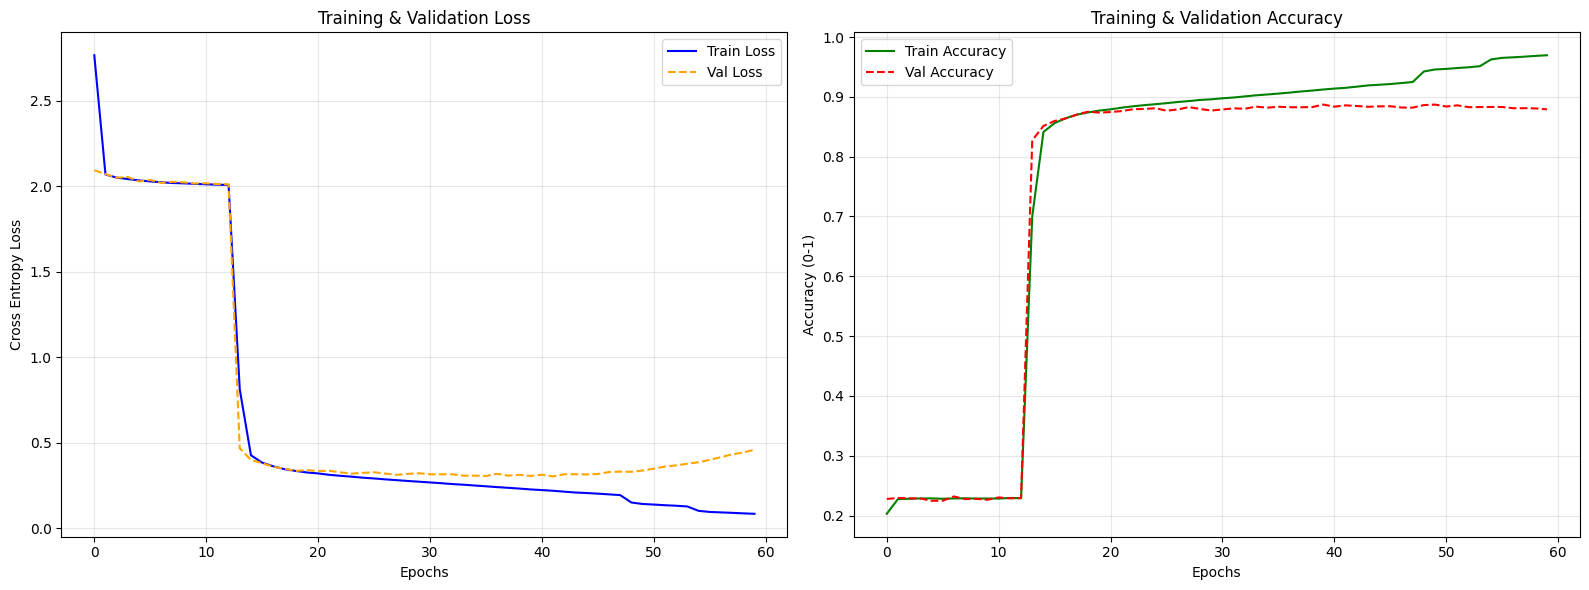

In [9]:
# 1. Hyperparameters Configuraton
LEARNING_RATE = 1e-3  
EPOCHS = 60          
DROPOUT = 0.0  # Dropout disabled to force learning.

# 2. Model Initialization
model = TSPTransformer(
    n=20, d_model=128, 
    nhead_encoder=4, nhead_decoder=4, 
    n_encoder_layers=3, n_decoder_layers=3, 
    dropout=DROPOUT
).to(DEVICE)

# Optimizer AdamW 
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Lists for saving metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"Starting Final Training with Accuracy Tracking on {DEVICE}...")

for epoch in range(EPOCHS):
    # TRAINING STEP
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0
    
    for batch_X, batch_tour in train_loader:
        batch_X = batch_X.to(DEVICE)
        batch_tour = batch_tour.to(DEVICE)
        
        optimizer.zero_grad()
        
        decoder_input = batch_tour[:, :-1]
        target = batch_tour[:, 1:]
        
        logits = model(batch_X, decoder_input)
        
        # Computing Loss
        loss = criterion(logits.reshape(-1, 20), target.reshape(-1))
        
        loss.backward()
        
        # Clip gradients to stabilize
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_train_loss += loss.item()
        
        # COMPUTE TRAINING ACCURACY
        predictions = torch.argmax(logits, dim=-1) # Index with maximum probability
        correct = (predictions == target).sum().item()
        total_train_correct += correct
        total_train_samples += target.numel()
        
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_correct / total_train_samples
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    
    # VALIDATION STEP
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for batch_X, batch_tour in val_loader:
            batch_X = batch_X.to(DEVICE)
            batch_tour = batch_tour.to(DEVICE)
            
            decoder_input = batch_tour[:, :-1]
            target = batch_tour[:, 1:]
            
            logits = model(batch_X, decoder_input)
            loss = criterion(logits.reshape(-1, 20), target.reshape(-1))
            total_val_loss += loss.item()
            
            # COMPUTE ACCURACY VALIDATION
            predictions = torch.argmax(logits, dim=-1)
            correct = (predictions == target).sum().item()
            total_val_correct += correct
            total_val_samples += target.numel()
            
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_correct / total_val_samples
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    # Step scheduler
    scheduler.step(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        curr_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {avg_train_acc*100:.1f}% | Val Acc: {avg_val_acc*100:.1f}% | LR: {curr_lr:.6f}")

# PLOTTING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Grafico 1: Loss
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='orange', linestyle='--')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross Entropy Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Grafico 2: Accuracy
ax2.plot(train_accuracies, label='Train Accuracy', color='green')
ax2.plot(val_accuracies, label='Val Accuracy', color='red', linestyle='--')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (0-1)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Task 8 (3 pts)

Finally, evaluate your model as if it were a heuristic for solving the TSP. Compare its performance with other simple baselines, such as:

* A random tour sampled uniformly at random
* The greedy heuristic, where you start from a given city and repeatedly move to the closest unvisited one. Its theoretical performance guarantees are quite weak, but in practice it can sometimes work surprisingly well.

The code needed to run these baselines is already provided in the next cells. There is just something you may want to check in the second cell after this one.
Before using it, make sure you fully understand what each part of the provided code is doing.

At the very end, you should see something like this, with our trained model beating all the baselines:

```
Greedy TSP average gap: 0.171123
Random TSP average gap: 1.745515
Our TSP average gap: 0.05374
```



In [10]:
def transformer_tsp(G, model, start_node=0, DEVICE="cpu"):
    """
    Evaluate a trained Transformer-based TSP heuristic on a given graph G.

    This function performs greedy autoregressive decoding: starting from node 0,
    it repeatedly queries the model to predict the next city to visit, always
    selecting the highest-scoring unvisited node. The predicted tour is finally
    closed by returning to the starting point.

    Parameters
    -----------
        G (networkx.Graph):
            A TSP instance where each node has a 'pos' attribute containing its
            2D coordinates.
        model (torch.nn.Module):
            A trained Transformer-like neural network that takes:
                - x: a tensor of node coordinates  
                - y: the partial tour so far       
              and outputs logits for the next node at each decoding step.
        start_node (int):
            The starting node; default is zero.
        DEVICE (str, optional):
            Device to run the model on (“cpu” or “cuda” (<-- GPU)). Default is "cpu".

    Returns:
    --------
        float:
            The length of the predicted tour, computed using `tour_length`.
    """
    model.eval()
    n = G.number_of_nodes()
    
    # 1. Extract coordinates
    attr = nx.get_node_attributes(G, "pos")
    coords = [attr[i] for i in range(n)]
    x = torch.tensor(coords, dtype=torch.float32)

    # 2. Min-Max Normalization 
    if x.numel() > 0:
        min_val = torch.min(x, dim=0)[0]
        max_val = torch.max(x, dim=0)[0]
        denom = max_val - min_val
        denom[denom == 0] = 1.0 
        x = (x - min_val) / denom

    x = x.to(DEVICE).unsqueeze(0) # [1, 20, 2]
    
    tour = [start_node]
    
    with torch.no_grad():
        for _ in range(n - 1):
            y = torch.tensor(tour, dtype=torch.long).to(DEVICE).unsqueeze(0)
            
            out = model(x, y)
            last_logits = out[:, -1, :] 
            
            # Greedy Selection
            _, sorted_indices = torch.topk(last_logits, n, dim=1)
            
            found = False
            for candidate in sorted_indices[0]:
                node = candidate.item()
                if node not in tour:
                    tour.append(node)
                    found = True
                    break
            
            if not found: 
                remaining = [i for i in range(n) if i not in tour]
                if remaining: tour.append(remaining[0])

    tour.append(start_node)
    return tour_length(G, tour)

In [11]:
# Evaluation Loop

# Ensure test data is assigned to X_test
X_test = test_data 

optimal_tours_values = []
greedy_tsp_values = []
random_tsp_values = []
our_heuristic_values = []

print(f"Starting evaluation on {len(X_test)} graphs...")

# Loop through the test set
for idx, (G, y_opt) in tqdm(enumerate(X_test), total=len(X_test)):
    
    # 1. Optimal Tour 
    # y_opt is the list of indices of the optimal tour provided in the dataset
    optimal_tours_values.append(tour_length(G, y_opt))

    # 2. Greedy TSP 
    tour_greedy = greedy_tsp(G, source=0)
    greedy_tsp_values.append(tour_length(G, tour_greedy))

    # 3. Random TSP 
    tour_random = random_tour(G)
    random_tsp_values.append(tour_length(G, tour_random))

    # 4. Our Transformer Heuristic
    try:
        # Run our model on the graph
        val = transformer_tsp(G, model, start_node=0, DEVICE=DEVICE)
        our_heuristic_values.append(val)
    except Exception as e:
        print(f"Error on graph {idx}: {e}")
        # If inference fails, append a very high cost
        our_heuristic_values.append(float('inf'))

print("Evaluation loop completed.")

Starting evaluation on 1000 graphs...


100%|██████████| 1000/1000 [01:26<00:00, 11.61it/s]

Evaluation loop completed.


In [12]:
# Gap Calculation and Results

# 1. Greedy TSP Gap
gaps_greedy = []
for i in range(len(X_test)):
    gap_val = gap(greedy_tsp_values[i], optimal_tours_values[i])
    gaps_greedy.append(gap_val)

print("Greedy TSP average gap:", np.mean(gaps_greedy))

# 2. Random TSP Gap
gaps_random = []
for i in range(len(X_test)):
    gap_val = gap(random_tsp_values[i], optimal_tours_values[i])
    gaps_random.append(gap_val)

print("Random TSP average gap:", np.mean(gaps_random))

# 3. Our Heuristic Gap
gaps_our = []
for i in range(len(X_test)):
    gap_val = gap(our_heuristic_values[i], optimal_tours_values[i])
    gaps_our.append(gap_val)

print("Our TSP average gap:", np.mean(gaps_our))

# Final Check
if np.mean(gaps_our) < 0.17:
    print("\nSUCCESS: Your model beat the Greedy baseline!")
else:
    print("\nRESULT: Model needs improvement. The gap is too high.")

Greedy TSP average gap: 0.1711230744772561
Random TSP average gap: 1.7242062290761115
Our TSP average gap: 0.0471357881023691

SUCCESS: Your model beat the Greedy baseline!


In [ ]:
# Final Verdict 
print("-" * 30)
if mean_our < mean_greedy:
    print("SUCCESS: Your model beat the Greedy baseline!")
    if mean_our < 0.10:
        print("EXCELLENT RESULT: Gap under the 10%!")
else:
    print("FAIL: The model underperforms compared to the Greedy approach. More training or normalization is required.")

Greedy TSP average gap: 0.1711230744772561
Random TSP average gap: 1.7242062290761115
Our TSP average gap:    0.0471357881023691
------------------------------
SUCCESS: Your model beat the Greedy baseline!
EXCELLENT RESULT: Gap under the 10%!


## Questions

1. Can you use this model for a TSP instance with 50 nodes? How can you improve it?
2. What is attention and why is it the core mechanism of Transformers?
3. How does multi-head attention differ from single-head attention? Why is it useful?
4. What is the purpose of positional encodings in a Transformer? Why are they needed?
5. Describe the role of the feed-forward network inside each Transformer layer.
6. Why do Transformers use Layer Normalization instead of Batch Normalization?
7.  What are Q, K, and V? Explain their dimensions intuitively.
8. Why do we scale the dot product by √dₖ in scaled dot-product attention?
9. What is the intuition behind causal masking?
11. What is the difference between training-time input and inference-time input in autoregressive models? What is teacher forcing? Why is it used?
12. What is tokenization and why does it matter for LLM performance?
13. What is the difference between pretraining and finetuning?
14. Explain greedy decoding vs. sampling vs. beam search.